# Feature selection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [ ]:
boston = datasets.load_boston()
print(boston.DESCR)

In [ ]:
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_df["MEDV"] = boston.target

boston_data = boston_df.drop("MEDV",1)  
boston_target = boston_df["MEDV"]   

boston_cols = list(boston_data.columns)

boston_df.head()

## Correlated features

In [ ]:
plt.figure(figsize=(12,10))

corr = boston_df.corr(method='spearman')
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)

plt.show()

In [ ]:
corr_target = abs(corr["MEDV"])

relevant_features = corr_target[corr_target > 0.6]

relevant_features

In [ ]:
print(boston_df[["RM", "LSTAT"]].corr())

## Select k best

In [ ]:
selector = SelectKBest(f_regression, k=4)

selector.fit(boston_data, boston_target)

print(selector.scores_)

selector.transform(boston_data).shape

## Recursive feature elimination
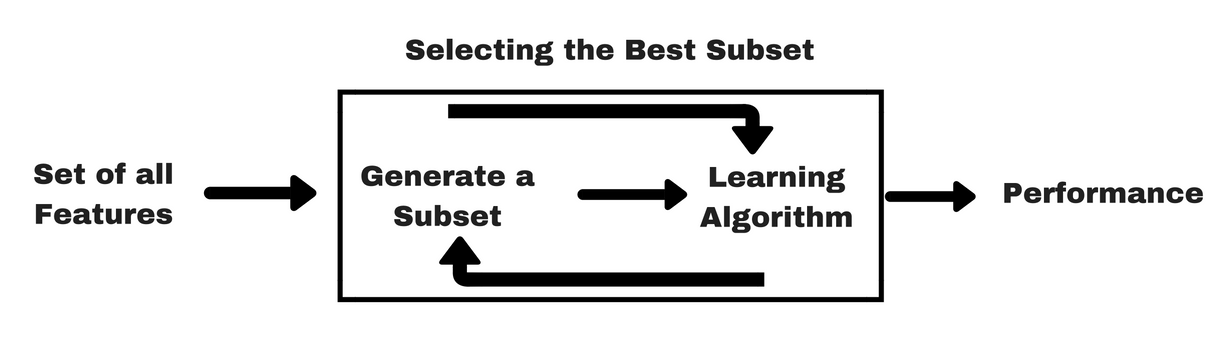

In [ ]:
linear_regression = LinearRegression()

print("Linear model RMSE:", round(cross_val_score(linear_regression, 
                                                  boston_data, boston_target, 
                                                  scoring = 'neg_root_mean_squared_error').mean(), 3))


In [ ]:

rfe = RFE(LinearRegression(), n_features_to_select = 5) 
rfe.fit(boston_data, boston_target)

print(rfe.support_)
print(rfe.ranking_)

In [ ]:
linear_regression = LinearRegression()

boston_data_rfe = rfe.fit_transform(boston_data,boston_target)  
print (boston_data_rfe.shape)

temp = pd.Series(rfe.support_,index = boston_cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

print("Linear model + RFE RMSE:", round(cross_val_score(linear_regression, 
                                                        boston_data_rfe, boston_target,
                                                        scoring = 'neg_root_mean_squared_error').mean(), 3))

## Embedded feature selection techniques 

In [ ]:
def pretty_print_coefs(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

In [ ]:
scaler = StandardScaler()

linear_regression = LinearRegression()
lasso_regression = Lasso()
ridge_regression = Ridge(alpha=1.0)

rf = RandomForestRegressor()

boston_data_scaled = scaler.fit_transform(boston_data)

linear_regression.fit(boston_data_scaled, boston_target)
lasso_regression.fit(boston_data_scaled, boston_target)  
ridge_regression.fit(boston_data_scaled, boston_target)  
rf.fit(boston_data_scaled, boston_target) 

print("Linear regression: ", pretty_print_coefs (linear_regression.coef_))
print("\nLasso regression: ", pretty_print_coefs(lasso_regression.coef_))
print("\nRidge regression: ", pretty_print_coefs(ridge_regression.coef_))

print("\nLinear model MSE:", round(cross_val_score(linear_regression, 
                                                   boston_data_scaled,boston_target, 
                                                   scoring = 'neg_root_mean_squared_error').mean(), 3))

print("\nLasso MSE:", round(cross_val_score(lasso_regression, 
                                            boston_data_scaled, boston_target,
                                            scoring = 'neg_root_mean_squared_error').mean(),3))

print("\nRidge MSE:", round(cross_val_score(ridge_regression, 
                                            boston_data_scaled, boston_target,
                                            scoring = 'neg_root_mean_squared_error').mean(),3))

print("\nRF MSE:", round(cross_val_score(rf, 
                                         boston_data_scaled, boston_target,
                                         scoring = 'neg_root_mean_squared_error').mean(), 3))

pd.DataFrame(rf.feature_importances_, boston_data.columns[:], 
             columns=['Importance']).sort_values('Importance', ascending=False)

## Principal component analysis

### Iris dataset

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

iris_df = pd.DataFrame(data = np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
iris_df.target = iris_df.target.replace(dict(enumerate(iris.target_names)))

sns.pairplot(iris_df, hue = 'target')

In [ ]:
iris_df.head()

### 2d irises

In [ ]:
pca_2 = PCA(n_components=4)
X_2D = pca_2.fit_transform(X)

print("Meaning of the 2 components:")

for component in pca_2.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))
plt.figure(figsize=(10,7))
plt.scatter(X_2D[:, 0], X_2D[:, 1], 
            c=y, s=70, cmap='viridis')

plt.show()


### Digits

In [ ]:
digits = datasets.load_digits()

X = digits.data
y = digits.target

pca = PCA(n_components = 2)
X_2d = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

In [ ]:
pd.DataFrame(data = np.c_[digits['data'], digits['target']],columns= digits['feature_names'] + ['target'])

### Components visualization

In [ ]:
n_components = 10

pca = PCA(n_components = n_components)
pca.fit_transform(X)

_, axes = plt.subplots(1, n_components , sharey=True, figsize=(n_components * 4, 6))

for i in range(0, n_components):
    im = pca.components_[i]
    axes[i].imshow(im.reshape((8, 8)), cmap='binary')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title( str(i + 1) + 'th principal component')

plt.show()

## t-SNE

In [ ]:
%time
from sklearn.manifold import TSNE

digits = datasets.load_digits()

X = digits.data
y = digits.target

tsne = TSNE(n_components=2, random_state=5)

X_2d = tsne.fit_transform(X)
target_ids = range(len(digits.target_names))

plt.figure(figsize=(10, 9))

colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'

for i, c, label in zip(target_ids, colors, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)

plt.legend()
plt.show()

In [ ]:
TSNE?